# Node classification with Personalised Propagation of Neural Predictions (PPNP) and Approximate PPNP (APPNP)

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/ppnp-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/ppnp-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

Import NetworkX and stellargraph:

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer.ppnp import PPNP
from stellargraph.layer.appnp import APPNP

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the CORA network

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [6]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [7]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

Note using stratified sampling gives the following counts:

In [8]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be compared against the model's soft-max output.

In [9]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

## Creating the PPNP model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

To feed data from the graph to the Keras model we need a generator. Since PPNP is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and the normalized graph Laplacian matrix to the model.

Specifying the `method='ppnp'` argument to the `FullBatchNodeGenerator` will preprocess the adjacency matrix and supply the personalized page rank matrix necessary for PPNP.  The personalized page rank matrix is a dense matrix and so `sparse=False` must be passed to `FullBatchNodeGenerator`. `teleport_probability=0.1` specifies the probability of returning to the starting node in the propagation step as described in the paper (alpha in the paper). 

In [10]:
generator = FullBatchNodeGenerator(
    G, method="ppnp", sparse=False, teleport_probability=0.1
)

For training we map only the training nodes returned from our splitter and the target values.

In [11]:
train_gen = generator.flow(train_subjects.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each full fully connected layer in the model. In this example we use three fully connected layers with 64,64, and 7 hidden node features at each layer. 
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 
 * `kernel_regularizer=keras.regularizers.l2(0.001)` specifies a penalty that prevents the model weights from become too large and helps limit overfitting
 
**Note that the size of the final fully connected layer must be equal to the number of classes you are trying to predict.**


We create a PPNP model as follows:

In [12]:
ppnp = PPNP(
    layer_sizes=[64, 64, train_targets.shape[-1]],
    activations=["relu", "relu", "relu"],
    generator=generator,
    dropout=0.5,
    kernel_regularizer=keras.regularizers.l2(0.001),
)

x_inp, x_out = ppnp.in_out_tensors()
predictions = keras.layers.Softmax()(x_out)

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [13]:
ppnp_model = Model(inputs=x_inp, outputs=predictions)
ppnp_model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [14]:
val_gen = generator.flow(val_subjects.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [15]:
if not os.path.isdir("logs"):
    os.makedirs("logs")

In [16]:
es_callback = EarlyStopping(
    monitor="val_acc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_ppnp_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [17]:
history = ppnp_model.fit(
    train_gen,
    epochs=80,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

  ['...']
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/80
1/1 - 1s - loss: 2.1556 - acc: 0.1571 - val_loss: 2.0886 - val_acc: 0.3340
Epoch 2/80
1/1 - 0s - loss: 2.0775 - acc: 0.2643 - val_loss: 2.0250 - val_acc: 0.3020
Epoch 3/80
1/1 - 0s - loss: 2.0350 - acc: 0.3357 - val_loss: 1.9640 - val_acc: 0.3020
Epoch 4/80
1/1 - 0s - loss: 1.9686 - acc: 0.3500 - val_loss: 1.9072 - val_acc: 0.3020
Epoch 5/80
1/1 - 0s - loss: 1.9118 - acc: 0.3286 - val_loss: 1.8519 - val_acc: 0.3020
Epoch 6/80
1/1 - 0s - loss: 1.8614 - acc: 0.3286 - val_loss: 1.7883 - val_acc: 0.3300
Epoch 7/80
1/1 - 0s - loss: 1.8051 - acc: 0.3286 - val_loss: 1.7203 - val_acc: 0.3480
Epoch 8/80
1/1 - 0s - loss: 1.7383 - acc: 0.3786 - val_loss: 1.6565 - val_acc: 0.4700
Epoch 9/80
1/1 - 0s - loss: 1.7872 - acc: 0.3571 - val_loss: 1.6091 - val_acc: 0.6800
Epoch 10/80
1/1 - 0s - loss: 1.6437 - acc: 0.4929 - val_loss: 1.5580 - val_acc: 0.7120
Epoch 11/80
1/1 - 0s - loss: 1.5356 - acc: 0.6286 - val_loss: 1.4868 - val_acc:

Plot the training history:

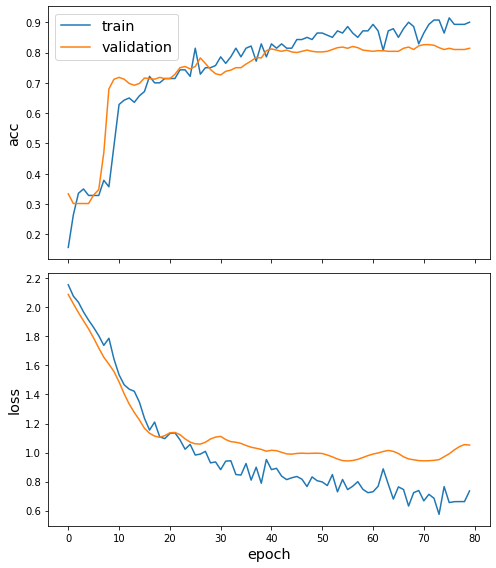

In [18]:
sg.utils.plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [19]:
ppnp_model.load_weights("logs/best_ppnp_model.h5")

Evaluate the best model on the test set

In [20]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [21]:
test_metrics = ppnp_model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(ppnp_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 15ms/step - loss: 0.8854 - acc: 0.8351

Test Set Metrics:
	loss: 0.8854
	acc: 0.8351


## Using the Approximate PPNP Model

Lets repeat the training and testing steps with the APPNP model using the same dataset. The downside of the PPNP is that you have to invert the adjacency matrix - which is time inefficient for large graphs - and store that invert matrix - which is space inefficient. The approximate model avoids this issue by using a clever mathematical trick. 

The APPNP model uses the normalized graph Laplacian. To get the normalized graph Laplacian we create a new `FullBatchNodeGenerator` and set `method="gcn"`. We have the option of choosing `sparse=True` or `sparse=False` but will use `sparse=True` for memory efficiency.

In [22]:
generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)

train_gen = generator.flow(train_subjects.index, train_targets)
val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

appnp = APPNP(
    layer_sizes=[64, 64, train_targets.shape[-1]],
    activations=["relu", "relu", "relu"],
    bias=True,
    generator=generator,
    teleport_probability=0.1,
    dropout=0.5,
    kernel_regularizer=keras.regularizers.l2(0.001),
)

x_inp, x_out = appnp.in_out_tensors()
predictions = keras.layers.Softmax()(x_out)

appnp_model = keras.models.Model(inputs=x_inp, outputs=predictions)
appnp_model.compile(
    loss="categorical_crossentropy",
    metrics=["acc"],
    optimizer=keras.optimizers.Adam(lr=0.01),
)

es_callback = EarlyStopping(
    monitor="val_acc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_appnp_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

history = appnp_model.fit(
    train_gen,
    epochs=120,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Using GCN (local pooling) filters...
  ['...']
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/120
1/1 - 1s - loss: 2.1611 - acc: 0.1571 - val_loss: 2.0960 - val_acc: 0.3500
Epoch 2/120
1/1 - 0s - loss: 2.0830 - acc: 0.3214 - val_loss: 2.0560 - val_acc: 0.3780
Epoch 3/120
1/1 - 0s - loss: 2.0771 - acc: 0.2214 - val_loss: 2.0171 - val_acc: 0.3200
Epoch 4/120
1/1 - 0s - loss: 2.0152 - acc: 0.3286 - val_loss: 1.9767 - val_acc: 0.3040
Epoch 5/120
1/1 - 0s - loss: 1.9555 - acc: 0.3143 - val_loss: 1.9280 - val_acc: 0.3040
Epoch 6/120
1/1 - 0s - loss: 1.9276 - acc: 0.3357 - val_loss: 1.8699 - val_acc: 0.3160
Epoch 7/120
1/1 - 0s - loss: 1.9307 - acc: 0.3500 - val_loss: 1.8084 - val_acc: 0.3820
Epoch 8/120
1/1 - 0s - loss: 1.8068 - acc: 0.4286 - val_loss: 1.7449 - val_acc: 0.5320
Epoch 9/120
1/1 - 0s - loss: 1.7419 - acc: 0.4357 - val_loss: 1.6791 - val_acc: 0.6180
Epoch 10/120
1/1 - 0s - loss: 1.7992 - acc: 0.4429 - val_loss: 1.6142 - val_acc: 0.6160
Epoch 11/120
1/1 - 0s - loss: 1.

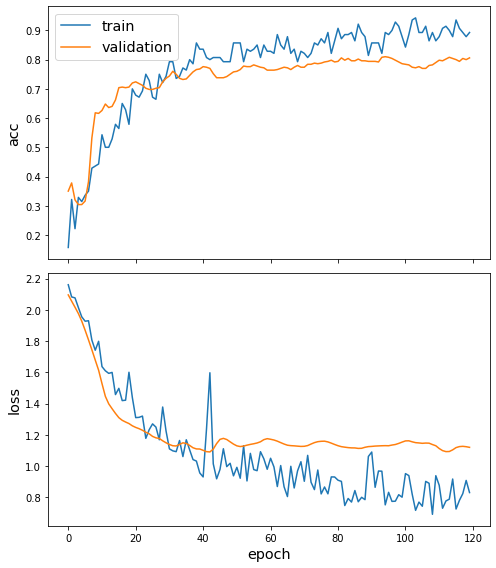

In [23]:
sg.utils.plot_history(history)

In [24]:
appnp_model.load_weights("logs/best_appnp_model.h5")
test_metrics = appnp_model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(appnp_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 8ms/step - loss: 1.0577 - acc: 0.8158

Test Set Metrics:
	loss: 1.0577
	acc: 0.8158


### Scalable APPNP Training

Now we're going to exploit the structure of PPNP for scalable training. PPNP consists of a fully-connected neural network followed by a graph propagation step. For each node, the fully-connected network outputs a score for each class and the propagation step basically takes a weighted average of scores of nearby nodes (closer nodes are weighted higher). 

Above, we trained the whole network end-to-end which obtains the most accurate results but  requires us to load the entire graph onto our GPU memory. This is because we need the entire graph for the propagation step. Unfortunately, this limits the graph size by our GPU memory. To get around this, we can train the fully-connected network separately and once we have a trained fully connected network we can add the graph propagation step.  The advantage of this approach is that we can train on batches of node features instead of the entire graph.

The model in the propagation step can be any Keras model trained on node features to predict the target classes. In this example we use a fully connected neural network with bag of word features as input. We could easily swap out the bag of words features for the complete text and replace the fully connected network with a state-of-the-art NLP model (for example BERT [1]), fine-tune the model and propagate its predictions.


<br>

1. Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. https://arxiv.org/abs/1810.04805

First we create and train a fully connected model.

In [25]:
model = keras.models.Model()

in_layer = layers.Input(shape=(G.node_feature_sizes()["paper"],))

layer = layers.Dropout(0.5)(in_layer)
layer = layers.Dense(64, activation="relu", kernel_regularizer="l2")(layer)
layer = layers.Dropout(0.5)(layer)
layer = layers.Dense(64, activation="relu", kernel_regularizer="l2")(layer)
layer = layers.Dropout(0.5)(layer)

# note the dimension of the output should equal the number of classes to predict!
layer = layers.Dense(train_targets.shape[-1], activation="relu")(layer)
layer = layers.Softmax()(layer)

fully_connected_model = keras.models.Model(inputs=in_layer, outputs=layer)

fully_connected_model.compile(
    loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizers.Adam(lr=0.01)
)

# the inputs are just the node features
X_train = G.node_features(train_subjects.index)
X_val = G.node_features(val_subjects.index)

In [26]:
es_callback = EarlyStopping(
    monitor="val_acc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_fc_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

history = fully_connected_model.fit(
    X_train,
    train_targets,
    validation_data=(X_val, val_targets),
    epochs=2000,
    batch_size=200,
    shuffle=True,  # we can shuffle the data here as
    callbacks=[es_callback, mc_callback],
)  # we're only working with node features

Train on 140 samples, validate on 500 samples
Epoch 1/2000
140/140 [==============================] - 0s 3ms/sample - loss: 3.8201 - acc: 0.1286 - val_loss: 3.2912 - val_acc: 0.3080
Epoch 2/2000
140/140 [==============================] - 0s 83us/sample - loss: 3.2808 - acc: 0.2714 - val_loss: 2.9294 - val_acc: 0.3020
Epoch 3/2000
140/140 [==============================] - 0s 78us/sample - loss: 2.8792 - acc: 0.3214 - val_loss: 2.6845 - val_acc: 0.3020
Epoch 4/2000
140/140 [==============================] - 0s 84us/sample - loss: 2.6692 - acc: 0.3071 - val_loss: 2.5253 - val_acc: 0.3020
Epoch 5/2000
140/140 [==============================] - 0s 92us/sample - loss: 2.4449 - acc: 0.3214 - val_loss: 2.4298 - val_acc: 0.3020
Epoch 6/2000
140/140 [==============================] - 0s 79us/sample - loss: 2.3284 - acc: 0.3143 - val_loss: 2.3773 - val_acc: 0.3020
Epoch 7/2000
140/140 [==============================] - 0s 83us/sample - loss: 2.2412 - acc: 0.3286 - val_loss: 2.3464 - val_acc: 0.3

By itself the fully connected model only gets ~60% accuracy on the test set.

In [27]:
X_test = G.node_features(test_subjects.index)

fully_connected_model.load_weights("logs/best_fc_model.h5")
test_metrics = fully_connected_model.evaluate(X_test, test_targets, verbose=2)
print("\nTest Set Metrics:")
for name, val in zip(fully_connected_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2068/2068 - 0s - loss: 1.8196 - acc: 0.5793

Test Set Metrics:
	loss: 1.8196
	acc: 0.5793


Now we propagate the fully connected network - no extra training required and we can re-use the APPNP object we've already created. First we create an intermediate fully connected model without the softmax layer, this is to avoid propagating the softmax layer which may cause issues with further training. We then propagate this intermediate network.

In [28]:
intermediate_model = Model(
    inputs=fully_connected_model.inputs, outputs=fully_connected_model.layers[-2].output
)

x_inp, x_out = appnp.propagate_model(intermediate_model)
predictions = keras.layers.Softmax()(x_out)

propagated_model = keras.models.Model(inputs=x_inp, outputs=predictions)
propagated_model.compile(
    loss="categorical_crossentropy",
    metrics=["acc"],
    optimizer=keras.optimizers.Adam(lr=0.01),
)

Our accuracy is better than the fully connected network by itself but less than end-to-end trained PPNP and APPNP. 

Note that this is partially because 140 data points isn't sufficient for the fully connected model to achieve optimal performance. As the number of training nodes increases the performance gap shrinks. 

In [29]:
test_metrics = propagated_model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(propagated_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 208ms/step - loss: 1.6038 - acc: 0.7273

Test Set Metrics:
	loss: 1.6038
	acc: 0.7273


### Making predictions with the model

Now let's get the predictions for all nodes.

In [30]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = propagated_model.predict(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories.

Note that for full-batch methods the batch size is 1 and the predictions have shape $(1, N_{nodes}, N_{classes})$ so we remove the batch dimension to obtain predictions of shape $(N_{nodes}, N_{classes})$ using the NumPy `squeeze` method.

In [31]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [32]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Theory,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Genetic_Algorithms,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Genetic_Algorithms,Probabilistic_Methods
1107140,Case_Based,Theory
1102850,Neural_Networks,Neural_Networks
31349,Probabilistic_Methods,Neural_Networks
1106418,Theory,Theory


Now we have an accurate model that can handle large graphs.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/ppnp-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/ppnp-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>